In [1]:
import itertools
import numpy as np
import pandas as pd
from plotnine import *
from scipy import stats
import sys

# read in custom modules
sys.path.append('/Users/rosekantor/work/wbe_data_analysis/')
from wbe.process_qpcr import *

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
ddpcr_raw = pd.read_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/supplementary_tables_ddPCR_raw_data.csv', skiprows=1)
dpcr_raw = pd.read_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/supplementary_tables_dPCR_raw_data.csv', skiprows=1)
qpcr_raw = pd.read_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/supplementary_tables_qPCR_raw_data.csv', skiprows=1)

# dPCR: Summarize data

In [3]:
dpcr_raw.Dilution = pd.to_numeric(dpcr_raw.Dilution)
dpcr_raw['gc_per_uL_RNA'] = pd.to_numeric(dpcr_raw.gc_per_uL_RNA)

# set up positives to get the result column
dpcr_raw.Positives = pd.to_numeric(dpcr_raw.Positives)
dpcr_df = dpcr_raw.groupby(['Sample', 'Target']).agg(
                                                    gc_per_uL_RNA=('gc_per_uL_RNA', 'mean'),
                                                    positives_sum=('Positives','sum')).reset_index() # two reps were run, avg gc and sum positives

# require both replicates to have 3 total positive partitions
dpcr_df['Result'] = 'Negative'
dpcr_df.loc[dpcr_df.positives_sum >= 3, 'Result'] = 'Positive'
dpcr_df['Dilution'] = 1 # no diluted samples were tested on the full sample set
dpcr_df = dpcr_df.drop(columns='positives_sum')
dpcr_df['Method'] = 'dPCR'

In [4]:
dpcr_df.head()

,Sample,Target,gc_per_uL_RNA,Result,Dilution,Method
0,A_A_INF_120820_1,BCoV,5530.455,Positive,1,dPCR
1,A_A_INF_120820_1,N1,1.080,Negative,1,dPCR
2,A_A_INF_120820_1,N2,11.610,Positive,1,dPCR
3,A_A_INF_120820_1,PMMoV,1133.055,Positive,1,dPCR
4,B_B_RV_120820_1,BCoV,6960.195,Positive,1,dPCR


In [5]:
display(dpcr_df[(dpcr_df.Target=='N1') & (dpcr_df.gc_per_uL_RNA > 0)].gc_per_uL_RNA.min())
display(dpcr_df[(dpcr_df.Target=='N1') & (dpcr_df.gc_per_uL_RNA > 0)].gc_per_uL_RNA.max())

display(dpcr_df[(dpcr_df.Target=='PMMoV') & (dpcr_df.gc_per_uL_RNA > 0)].gc_per_uL_RNA.min())
display(dpcr_df[(dpcr_df.Target=='PMMoV') & (dpcr_df.gc_per_uL_RNA > 0)].gc_per_uL_RNA.max())

0.54

271.755

359.55

38672.91

# ddPCR: summarize data

In [6]:
ddpcr_df = ddpcr_raw[~ddpcr_raw.Sample.isin(['NTC', 'PC', 'PC+MHV'])].copy() # drop controls
ddpcr_df['Method'] = 'ddPCR'

ddpcr_df.loc[ddpcr_df.Result.isna(), 'Result'] = 'Negative'
ddpcr_df.loc[(ddpcr_df.Positives >= 3) & (ddpcr_df.Target != 'N1'), 'Result'] = 'Positive'

ddpcr_df = ddpcr_df.drop(columns=['gc_per_uL_rxn_mixture', 'Positives', 'Plate', 'Lambda', 'Accepted Droplets'])

ddpcr_df.head()

,Target,Sample,Dilution,gc_per_uL_RNA,Result,spike_MHV_gc,Method
0,N2,Q_Q_CMF_120720_1,1.0,3.04,Positive,708000.0,ddPCR
1,N2,Q_Q_CMF_120720_1,10.0,2.89,Negative,708000.0,ddPCR
2,N2,B_B_SQ_120520_1,1.0,0.18,Negative,708000.0,ddPCR
3,N2,B_B_SQ_120520_1,10.0,0.00,Negative,708000.0,ddPCR
4,N2,B_B_SQ_120620_1,1.0,0.16,Negative,708000.0,ddPCR


In [7]:
display(ddpcr_df[(ddpcr_df.Target=='N1') & (ddpcr_df.gc_per_uL_RNA > 0)].gc_per_uL_RNA.min())
display(ddpcr_df[(ddpcr_df.Target=='N1') & (ddpcr_df.gc_per_uL_RNA > 0)].gc_per_uL_RNA.max())

display(ddpcr_df[(ddpcr_df.Target=='PMMoV') & (ddpcr_df.gc_per_uL_RNA > 0)].gc_per_uL_RNA.min())
display(ddpcr_df[(ddpcr_df.Target=='PMMoV') & (ddpcr_df.gc_per_uL_RNA < 2222222.22)].gc_per_uL_RNA.max())

0.34

289.08

315.68

123673.39

In [8]:
mhv_df = ddpcr_df[(ddpcr_df.Target == 'MHV') & (ddpcr_df.Dilution == 10)].copy()

# NOTE: spike_MHV_gc is the total gene copies of MHV spiked into 40 mL wastewater
# 200 ul elution volume represents the total 40 mL sample extracted

mhv_df['recovered_mhv_gc'] = mhv_df.gc_per_uL_RNA * 200 
mhv_df['recovery_perc'] = 100 * mhv_df.recovered_mhv_gc / mhv_df.spike_MHV_gc

mhv_df

,Target,Sample,Dilution,gc_per_uL_RNA,Result,spike_MHV_gc,Method,recovered_mhv_gc,recovery_perc
215,MHV,Q_Q_CMF_120720_1,10.0,5331.56,Positive,708000.0,ddPCR,1066312.0,150.609040
217,MHV,B_B_SQ_120520_1,10.0,2001.78,Positive,708000.0,ddPCR,400356.0,56.547458
219,MHV,B_B_SQ_120620_1,10.0,3180.67,Positive,708000.0,ddPCR,636134.0,89.849435
221,MHV,H_H_INF_120320_1,10.0,1914.22,Positive,708000.0,ddPCR,382844.0,54.074011
223,MHV,J_J_UCV_120820_1,10.0,4430.00,Positive,708000.0,ddPCR,886000.0,125.141243
225,MHV,J_J_Kerr_120820_1,10.0,2602.67,Positive,708000.0,ddPCR,520534.0,73.521751
227,MHV,K_K_INF_120720_1,10.0,2298.89,Positive,708000.0,ddPCR,459778.0,64.940395
229,MHV,M_M_INF_120620_1,10.0,3091.56,Positive,708000.0,ddPCR,618312.0,87.332203
231,MHV,M_M_INF_120820_1,10.0,1838.44,Positive,708000.0,ddPCR,367688.0,51.933333
233,MHV,N_N_INF_120820_1,10.0,3528.22,Positive,708000.0,ddPCR,705644.0,99.667232


In [9]:
# get list of all samples analyzed with dPCR and ddPCR
samples = set(pd.concat([ddpcr_df.Sample, dpcr_df.Sample]))

# qPCR: process and summarize data

Four of the standard curves for PMMoV were made with an RNA ultramer that had degraded. These curves should be replaced with the curve from plate 1138 (made with gBlock linear DNA standard) prior to analysis. See plot below:

## Figure S1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


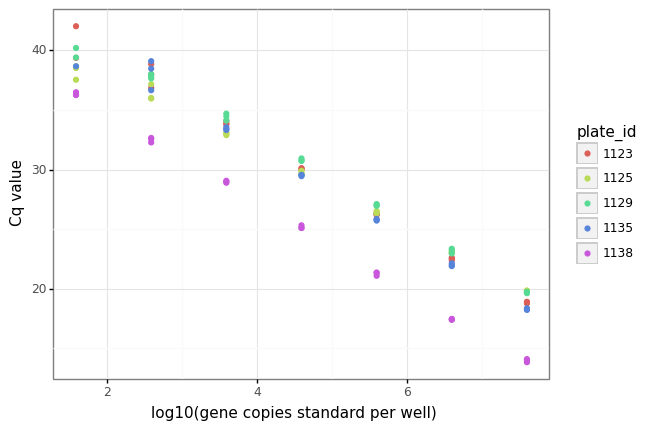

<ggplot: (343698511)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/FigS1.png
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


In [10]:
compare_curves = qpcr_raw[(qpcr_raw.Target=='PMMoV') &
                         (qpcr_raw.Task=='Standard')].sort_values(['Quantity', 'plate_id'])[['plate_id', 'Quantity', 'Cq']]

compare_curves['log10_quantity'] = np.log10(compare_curves.Quantity)
compare_curves.plate_id = pd.Categorical(compare_curves.plate_id)

plt = (ggplot(compare_curves, aes(x='log10_quantity', y='Cq', color='plate_id'))+
 geom_point()+
 xlab('log10(gene copies standard per well)')+
 ylab('Cq value')+
 theme_bw())

display(plt)
ggsave(plt, '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/FigS1.png')

In [11]:
# dilution must be lowercase for the processing code
qpcr_raw = qpcr_raw.rename(columns={'Dilution':'dilution'})

In [12]:
# separate standards and nonstandards
standards = qpcr_raw[qpcr_raw.Task == 'Standard']
nonstandards = qpcr_raw[qpcr_raw.Task != 'Standard']
standardsN1 = standards[standards.Target == 'N1'].copy()
standardsPMMoV = standards[standards.Target == 'PMMoV'].copy()
standardsbCoV = standards[standards.Target == 'bCoV'].copy()

# substitute in standards from plate 1138 for standards from plate 1123, 1125, and 1129 (so they will all use the same standard curve)
standardsPMMoV = standardsPMMoV[standardsPMMoV.plate_id == 1138].sort_values('Quantity')

standardsPMMoV1123 = standardsPMMoV.copy()
standardsPMMoV1123.plate_id = 1123

standardsPMMoV1125 = standardsPMMoV.copy()
standardsPMMoV1125.plate_id = 1125

standardsPMMoV1129 = standardsPMMoV.copy()
standardsPMMoV1129.plate_id = 1129

standardsPMMoV1135 = standardsPMMoV.copy()
standardsPMMoV1135.plate_id = 1135

standardsPMMoV = pd.concat([standardsPMMoV1123, standardsPMMoV1125, standardsPMMoV1129, standardsPMMoV1135, standardsPMMoV])

all_standards = pd.concat([standardsN1, standardsPMMoV, standardsbCoV])

plate_df_stds_subbed = pd.concat([nonstandards, all_standards])

In [13]:
# process the qPCR data to calculate gene copies per well using function from the wbe module
qpcr, plate_target_info = process_qpcr_plate(plate_df_stds_subbed)

In [14]:
# view qPCR plate data
plate_target_info.sort_values('Target')

,num_points,slope,intercept,r2,efficiency,loq_Cq,loq_Quantity,used_default_curve,plate_id,Target,intraassay_var,ntc_is_neg,ntc_Cq,Target_full
0,6,-3.738818,38.998471,0.997568,0.851246,36.059030,6.078,False,1122,N1,30.879475,True,NaN,[N1]
0,5,-3.876210,39.419430,0.998919,0.811273,35.434480,12.156,False,1124,N1,25.195222,True,NaN,[N1]
0,5,-3.674994,39.564283,0.999749,0.871153,35.632350,12.156,False,1128,N1,91.724695,True,NaN,[N1]
0,6,-3.605862,39.658574,0.993775,0.893765,37.203805,3.039,False,1134,N1,21.152385,True,NaN,[N1]
0,5,-3.559740,39.004627,0.994445,0.909499,36.656105,3.039,False,1136,N1,19.190698,True,NaN,[N1]
0,5,-3.644856,39.067306,0.999175,0.880872,34.988675,12.156,False,1137,N1,19.400181,True,NaN,[N1]
0,7,-3.747799,42.309398,0.999782,0.848516,36.341716,39.210,False,1123,PMMoV,9.101383,True,NaN,[PMMoV]
0,7,-3.747799,42.309398,0.999782,0.848516,36.341716,39.210,False,1125,PMMoV,3.870927,False,42.20683,[PMMoV]
0,7,-3.747799,42.309398,0.999782,0.848516,36.341716,39.210,False,1129,PMMoV,5.095990,True,NaN,[PMMoV]
0,7,-3.747799,42.309398,0.999782,0.848516,36.341716,39.210,False,1135,PMMoV,67.631168,True,NaN,[PMMoV]


In [15]:
# the wbe package automatically substitutes 1/2 the previously determined LOD (2 gc/well) for any non-detect replicates before averaging
# to avoid this, we need to take the geometric mean of the Quantities without substitution
qpcr['Quantity_mean_nosub'] = qpcr.Quantity_no_outliers.apply(get_gmean)
qpcr = qpcr.rename(columns={'Quantity_mean':'Quantity_mean_lod_sub', 'Quantity_mean_nosub':'Quantity_mean'})

In [16]:
# format and calculate gc_per_ul
qpcr = qpcr.rename(columns={'dilution':'Dilution'})
qpcr = qpcr[['Sample', 'plate_id', 'Dilution', 'Quantity_mean', 'Cq', 'nondetect_count', 'Target']]
qpcr = qpcr[qpcr.Target.isin(['N1', 'PMMoV'])]

# correct for dilution factor and calculate concentration of RNA extract (5 ul used in 20 ul reaction)
qpcr['gc_per_uL_RNA'] = qpcr.Quantity_mean * qpcr.Dilution / 5 # Quantity_mean is gc per well, and each well had 5 ul of RNA template
qpcr = qpcr.drop(columns=['Quantity_mean'])
qpcr['Method'] = 'qPCR'

qpcr.loc[qpcr.gc_per_uL_RNA.isna(), 'gc_per_uL_RNA'] = 0 # convert NA to zero
qpcr['Cq_mean'] = qpcr.Cq.apply(np.mean)

qpcr = qpcr[qpcr.Sample.isin(samples)]
qpcr['num_tech_reps_of_3_detected'] = 3 - qpcr['nondetect_count']

# create Result column based on whether the sample met requirements to be positive (at least 2 wells amplified and the avg concentration was above the LOD, corrected for dilution)
qpcr['Result'] = 'Negative'
qpcr.loc[((qpcr.Dilution == 1) & (qpcr.gc_per_uL_RNA >= 0.49) & (qpcr.num_tech_reps_of_3_detected >= 2)), 'Result'] = 'Positive'
qpcr.loc[((qpcr.Dilution == 5) & (qpcr.gc_per_uL_RNA >= 0.49*5) & (qpcr.num_tech_reps_of_3_detected >= 2)), 'Result'] = 'Positive'
# convert nondetects to zeros (the processing code has replaced them with 1/2 the previously determined LOD based on Qubit of the standard; 0.40 or 2.0 if the 5x dilution)
qpcr.loc[qpcr.Result == 'Negative', 'gc_per_uL_RNA'] = 0

qpcr.loc[qpcr.Target == 'bCoV', 'Target'] = 'BCoV' # rename to match ddPCR and dPCR tables

In [17]:
qpcr_df = qpcr[['Sample', 'Target', 'Dilution', 'gc_per_uL_RNA', 'Result', 'Method']]
qpcr_df.head()

,Sample,Target,Dilution,gc_per_uL_RNA,Result,Method
0,B_B_SQ_120520_1,N1,1,0.000000,Negative,qPCR
1,B_B_SQ_120520_1,N1,5,0.000000,Negative,qPCR
2,B_B_SQ_120620_1,N1,1,0.625940,Positive,qPCR
3,B_B_SQ_120620_1,N1,5,4.257019,Positive,qPCR
4,D_OSP_INF_120820_1,N1,1,30.366421,Positive,qPCR


In [18]:
display(qpcr_df[(qpcr_df.Target=='N1') & (qpcr_df.gc_per_uL_RNA > 0)].gc_per_uL_RNA.min())
display(qpcr_df[(qpcr_df.Target=='N1') & (qpcr_df.gc_per_uL_RNA > 0)].gc_per_uL_RNA.max())

display(qpcr_df[(qpcr_df.Target=='PMMoV') & (qpcr_df.gc_per_uL_RNA > 0)].gc_per_uL_RNA.min())
display(qpcr_df[(qpcr_df.Target=='PMMoV') & (qpcr_df.gc_per_uL_RNA > 0)].gc_per_uL_RNA.max())

0.6259400228123821

5713.940532997314

620.0703331794441

67305.34715599117

# Merge data

## Concatenate - long

In [19]:
ddpcr_df = ddpcr_df.drop(columns=['spike_MHV_gc'])

all_long = pd.concat([qpcr_df, dpcr_df, ddpcr_df])

## Merge all data by sample - wide

In [20]:
# check for NAs in measurement prior to merging
display(qpcr_df[qpcr_df.gc_per_uL_RNA.isna()])
display(ddpcr_df[ddpcr_df.gc_per_uL_RNA.isna()])
display(dpcr_df[dpcr_df.gc_per_uL_RNA.isna()])

# after merging all data, any NaNs will mean that the sample wasn't run with a given platform

,Sample,Target,Dilution,gc_per_uL_RNA,Result,Method


,Target,Sample,Dilution,gc_per_uL_RNA,Result,Method


,Sample,Target,gc_per_uL_RNA,Result,Dilution,Method


In [21]:
all = qpcr_df.merge(ddpcr_df, on=['Sample', 'Target', 'Dilution'], how='outer', suffixes=('_qPCR', '_ddPCR'))
all = all.merge(dpcr_df, on=['Sample', 'Target', 'Dilution'], how='outer')
all = all.rename(columns={'gc_per_uL_RNA':'gc_per_uL_RNA_dPCR',
                          'Result': 'Result_dPCR'})
all = all.drop(columns=['Method_qPCR', 'Method_ddPCR', 'Method'])

In [22]:
all.head()

,Sample,Target,Dilution,gc_per_uL_RNA_qPCR,Result_qPCR,gc_per_uL_RNA_ddPCR,Result_ddPCR,gc_per_uL_RNA_dPCR,Result_dPCR
0,B_B_SQ_120520_1,N1,1.0,0.000000,Negative,0.00,Negative,0.000,Negative
1,B_B_SQ_120520_1,N1,5.0,0.000000,Negative,0.00,Negative,NaN,NaN
2,B_B_SQ_120620_1,N1,1.0,0.625940,Positive,0.00,Negative,0.000,Negative
3,B_B_SQ_120620_1,N1,5.0,4.257019,Positive,0.00,Negative,NaN,NaN
4,D_OSP_INF_120820_1,N1,1.0,30.366421,Positive,18.94,Positive,17.415,Positive


In [23]:
# show how long the dataframe is, dropping samples that weren't analyzed by all 3 methods
n1_all = all[(all.Target == 'N1') & (all.Dilution == 1) & (~all.gc_per_uL_RNA_qPCR.isna()) & (~all.gc_per_uL_RNA_dPCR.isna()) & (~all.gc_per_uL_RNA_ddPCR.isna())].dropna().copy()
n1_all_samples = set(n1_all.Sample)
len(n1_all_samples)

40

In [24]:
# PMMoV samples were analyzed at different dilutions depending on the platform, so to count the number of samples analyzed with all 3 platforms, we need the intersection of these sets
pmmov_qpcr = set(all[(all.Target == 'PMMoV') & (~all.gc_per_uL_RNA_qPCR.isna())].Sample)
pmmov_dpcr = set(all[(all.Target == 'PMMoV') & (~all.gc_per_uL_RNA_dPCR.isna())].Sample)
pmmov_ddpcr = set(all[(all.Target == 'PMMoV') & (~all.gc_per_uL_RNA_ddPCR.isna())].Sample)
pmmov_all_samples = set.intersection(pmmov_qpcr, pmmov_dpcr, pmmov_ddpcr)
len(pmmov_all_samples)

40

In [25]:
# how many sewersheds- extract sewershed from Sample ID
n1_all['sample_code'] = n1_all.Sample.str.extract(r'(\w+_\w+_\w+)_\d{6}_\d')

n1_all_sum = n1_all[['Sample', 'sample_code']].groupby('sample_code').agg('count').reset_index()
n1_all_sum.shape

(30, 2)

In [26]:
all = all[['Sample', 'Dilution', 'Target', 'gc_per_uL_RNA_qPCR', 'gc_per_uL_RNA_dPCR', 'gc_per_uL_RNA_ddPCR', 'Result_qPCR', 'Result_dPCR', 'Result_ddPCR']].copy()
all.Target = pd.Categorical(all.Target, ordered=True, categories=['N1', 'N2', 'PMMoV', 'BCoV', 'MHV', 'E'])
all = all.sort_values(['Target', 'Sample', 'Dilution'])
all.Dilution = pd.Categorical(all.Dilution)
#all.to_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/supplementary_tables_merged_pcr_data.csv', index=False)
all.head()

,Sample,Dilution,Target,gc_per_uL_RNA_qPCR,gc_per_uL_RNA_dPCR,gc_per_uL_RNA_ddPCR,Result_qPCR,Result_dPCR,Result_ddPCR
64,A_A_INF_120820_1,1.0,N1,19.175900,1.080,8.07,Positive,Negative,Positive
65,A_A_INF_120820_1,5.0,N1,33.616407,NaN,6.18,Positive,NaN,Positive
464,B_B_RV_120820_1,1.0,N1,NaN,6.885,12.95,NaN,Positive,Positive
465,B_B_RV_120820_1,5.0,N1,NaN,NaN,11.86,NaN,NaN,Positive
136,B_B_SD2_120920_1,1.0,N1,24.907725,17.415,20.70,Positive,Positive,Positive


# Compare N1 data

In [27]:
# make average rank column with wide formatted table to order samples for plotting

# first collect only the samples that were run with all methods at 1x dilution
n1 = all[(all.Target=='N1') & (all.Dilution==1)]
n1 = n1[n1.Sample.isin(n1_all_samples)]

# first sort and rank for each method
n1 = n1.sort_values('gc_per_uL_RNA_qPCR')
n1['rank_qpcr'] = range(0,len(n1))

n1 = n1.sort_values('gc_per_uL_RNA_dPCR')
n1['rank_dpcr'] = range(0,len(n1))

n1 = n1.sort_values('gc_per_uL_RNA_ddPCR')
n1['rank_ddpcr'] = range(0,len(n1))

# average all ranks and make ordered list (which will randomly split ties)
n1['avg_rank'] = n1[['rank_qpcr', 'rank_dpcr', 'rank_ddpcr']].mean(axis=1)

ranked_samples = n1.sort_values('avg_rank').Sample.to_list()

In [28]:
n1.head()

,Sample,Dilution,Target,gc_per_uL_RNA_qPCR,gc_per_uL_RNA_dPCR,gc_per_uL_RNA_ddPCR,Result_qPCR,Result_dPCR,Result_ddPCR,rank_qpcr,rank_dpcr,rank_ddpcr,avg_rank
0,B_B_SQ_120520_1,1.0,N1,0.000000,0.00,0.00,Negative,Negative,Negative,0,0,0,0.000000
2,B_B_SQ_120620_1,1.0,N1,0.625940,0.00,0.00,Positive,Negative,Negative,3,5,1,3.000000
104,D_SEP_Frank_121020_1,1.0,N1,0.000000,0.00,0.00,Negative,Negative,Negative,2,6,2,3.333333
144,J_J_Kerr_121020_1,1.0,N1,0.707228,0.54,0.34,Positive,Negative,Positive,4,8,3,5.000000
48,D_SEP_Koret_120820_1,1.0,N1,1.951214,0.00,0.55,Positive,Negative,Positive,8,1,4,4.333333


In [29]:
n1['qpcr_per_ddpcr'] = n1.gc_per_uL_RNA_qPCR / n1.gc_per_uL_RNA_ddPCR
n1['qpcr_per_dpcr'] = n1.gc_per_uL_RNA_qPCR / n1.gc_per_uL_RNA_dPCR
display(n1.qpcr_per_ddpcr.median())
display(n1.qpcr_per_dpcr.median())

1.834722091437869

1.713857409310295

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


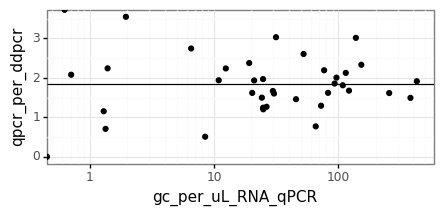

<ggplot: (343884532)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


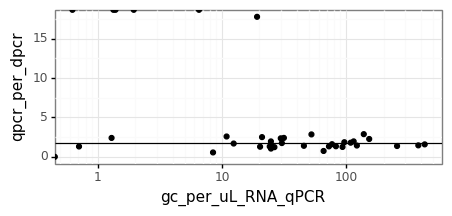

<ggplot: (343883629)>

In [30]:
plt1 = (ggplot(n1, aes(x='gc_per_uL_RNA_qPCR', y='qpcr_per_ddpcr'))+
geom_point()+
geom_hline(yintercept=n1.qpcr_per_ddpcr.median())+
scale_x_log10()+
theme_bw()+
theme(figure_size=(5,2)))

plt2 = (ggplot(n1, aes(x='gc_per_uL_RNA_qPCR', y='qpcr_per_dpcr'))+
geom_point()+
geom_hline(yintercept=n1.qpcr_per_dpcr.median())+
scale_x_log10()+
theme_bw()+
theme(figure_size=(5,2)))

display(plt1)
display(plt2)

In [31]:
all_long.head()

,Sample,Target,Dilution,gc_per_uL_RNA,Result,Method
0,B_B_SQ_120520_1,N1,1.0,0.000000,Negative,qPCR
1,B_B_SQ_120520_1,N1,5.0,0.000000,Negative,qPCR
2,B_B_SQ_120620_1,N1,1.0,0.625940,Positive,qPCR
3,B_B_SQ_120620_1,N1,5.0,4.257019,Positive,qPCR
4,D_OSP_INF_120820_1,N1,1.0,30.366421,Positive,qPCR


In [32]:
# prep dataframe for plotting

n1_plot_df = all_long[all_long.Target=='N1'].copy()
n1_plot_df = n1_plot_df[['Sample', 'Dilution', 'gc_per_uL_RNA', 'Result', 'Method']]
n1_plot_df.Sample = pd.Categorical(n1_plot_df.Sample, ordered=True, categories=ranked_samples)
n1_plot_df.Method = pd.Categorical(n1_plot_df.Method, ordered=True, categories=['qPCR', 'dPCR', 'ddPCR'])
n1_plot_df.Dilution = pd.Categorical(n1_plot_df.Dilution, categories=[1, 5])
n1_plot_df = n1_plot_df.dropna()

# We want to plot non-detects at the detection limit. 
qPCR_LOD = 0.49
dPCR_LOD = 0.2
ddPCR_LOD = 0.1 * 20/9

n1_plot_df.loc[(n1_plot_df.Method == 'qPCR') & (n1_plot_df.Result == 'Negative'), 'gc_per_uL_RNA'] = qPCR_LOD
n1_plot_df.loc[(n1_plot_df.Method == 'dPCR') & (n1_plot_df.Result == 'Negative'), 'gc_per_uL_RNA'] = dPCR_LOD
n1_plot_df.loc[(n1_plot_df.Method == 'ddPCR') & (n1_plot_df.Result == 'Negative'), 'gc_per_uL_RNA'] = ddPCR_LOD

In [33]:
n1_plot_df.head()

,Sample,Dilution,gc_per_uL_RNA,Result,Method
0,B_B_SQ_120520_1,1,0.490000,Negative,qPCR
1,B_B_SQ_120520_1,5,0.490000,Negative,qPCR
2,B_B_SQ_120620_1,1,0.625940,Positive,qPCR
3,B_B_SQ_120620_1,5,4.257019,Positive,qPCR
4,D_OSP_INF_120820_1,1,30.366421,Positive,qPCR


In [34]:
# create a second dataframe with only the below LOD points so we can plot these as open shapes on top of the other plot below
blod = n1_plot_df[n1_plot_df.Result=='Negative'].copy()

## Figure 1

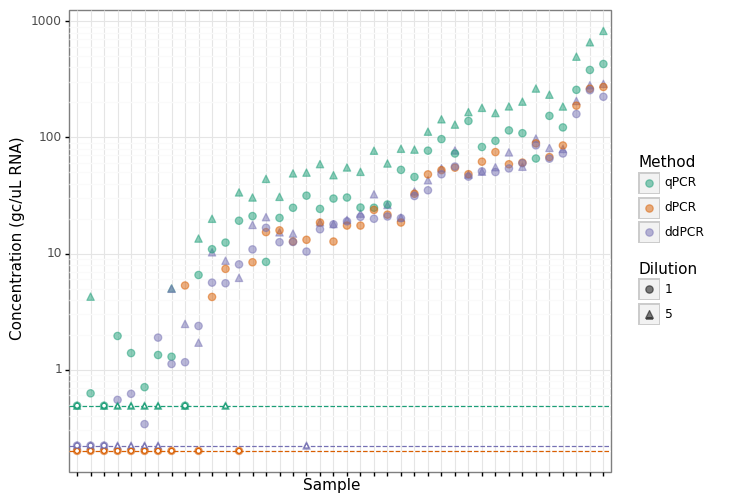

<ggplot: (377503979)>

In [35]:
colors=['#1b9e77', '#d95f02', '#7570b3']

N1plot = (ggplot(n1_plot_df, aes(x='Sample', y='gc_per_uL_RNA', color='Method', shape='Dilution'))+
  geom_hline(yintercept=qPCR_LOD, linetype='dashed', color=colors[0]) +
  geom_hline(yintercept=dPCR_LOD, linetype='dashed', color=colors[1]) +
  geom_hline(yintercept=ddPCR_LOD, linetype='dashed', color=colors[2]) +
  geom_point(alpha=0.5, size=2.5)+
  geom_point(blod, aes(x='Sample', y='gc_per_uL_RNA', color='Method', shape='Dilution'), fill='white', show_legend='none')+ 
  
  xlab('Sample')+
  ylab('Concentration (gc/uL RNA)')+
  scale_color_manual(values=colors)+
  scale_y_continuous(trans = 'log10') +

  
  theme_bw() + 
  theme(axis_text_x=element_blank(), figure_size=(7,6))
)

display(N1plot)
# ggsave(N1plot, '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/Fig1.pdf')
# ggsave(N1plot, '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/Fig1.png')

# Compare PMMoV data

In [36]:
# make average rank column with wide formatted table to order samples for plotting

pmmov = all[(all.Target=='PMMoV')].copy()

In [37]:
pmmov['qpcr_per_ddpcr'] = pmmov.gc_per_uL_RNA_qPCR / pmmov.gc_per_uL_RNA_ddPCR
pmmov['qpcr_per_dpcr'] = pmmov.gc_per_uL_RNA_qPCR / pmmov.gc_per_uL_RNA_dPCR
display(pmmov.qpcr_per_ddpcr.median())
display(pmmov.qpcr_per_dpcr.median())

1.263438757535026

1.1616319170375757

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 75 rows containing missing values.


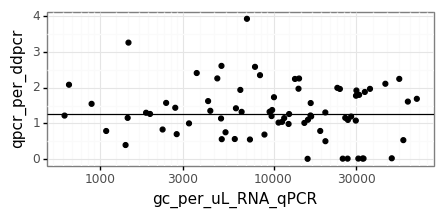

<ggplot: (377620209)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 116 rows containing missing values.


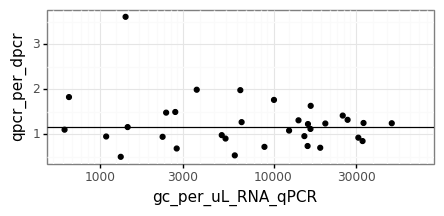

<ggplot: (343886306)>

In [38]:
plt1 = (ggplot(pmmov, aes(x='gc_per_uL_RNA_qPCR', y='qpcr_per_ddpcr'))+
geom_point()+
geom_hline(yintercept=pmmov.qpcr_per_ddpcr.median())+
scale_x_log10()+
theme_bw()+
theme(figure_size=(5,2)))

plt2 = (ggplot(pmmov, aes(x='gc_per_uL_RNA_qPCR', y='qpcr_per_dpcr'))+
geom_point()+
geom_hline(yintercept=pmmov.qpcr_per_dpcr.median())+
scale_x_log10()+
theme_bw()+
theme(figure_size=(5,2)))

display(plt1)
display(plt2)

In [39]:
pmmov_ranked_samples = pmmov[~pmmov.gc_per_uL_RNA_dPCR.isna()].sort_values('gc_per_uL_RNA_dPCR').Sample

In [40]:
# prep dataframe for plotting

pmmov_plot_df = all_long[all_long.Target=='PMMoV'].copy()
pmmov_plot_df = pmmov_plot_df[['Sample', 'Dilution', 'gc_per_uL_RNA', 'Result', 'Method']]

pmmov_plot_df.Sample = pd.Categorical(pmmov_plot_df.Sample, ordered=True, categories=pmmov_ranked_samples)
pmmov_plot_df.Method = pd.Categorical(pmmov_plot_df.Method, ordered=True, categories=['qPCR', 'dPCR', 'ddPCR'])
pmmov_plot_df.Dilution = pd.Categorical(pmmov_plot_df.Dilution, categories=[1, 5, 50])
pmmov_plot_df = pmmov_plot_df.dropna()

## Figure S2

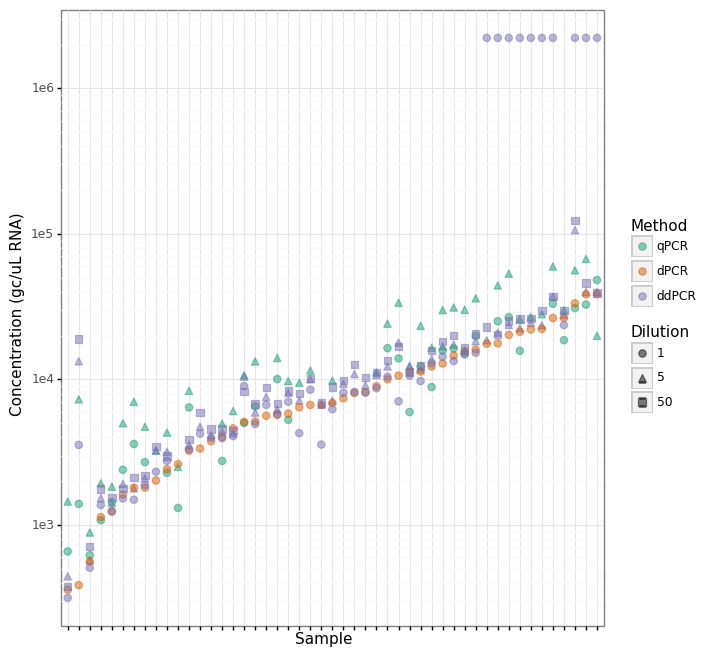

<ggplot: (377729021)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 8 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/FigS2.png


In [41]:
colors=['#1b9e77', '#d95f02', '#7570b3']

PMMoVplot = (ggplot(pmmov_plot_df, aes(x='Sample', y='gc_per_uL_RNA', color='Method', shape='Dilution'))+
  geom_point(alpha=0.5, size=2.5)+
  
  xlab('Sample')+
  ylab('Concentration (gc/uL RNA)')+
  scale_color_manual(values=colors)+
  scale_y_continuous(trans = 'log10') +

  
  theme_bw() + 
  theme(axis_text_x=element_blank(), figure_size=(7,8))
)

display(PMMoVplot)
ggsave(PMMoVplot, '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/FigS2.png')

# Linear regression and correlations

## Build table of correlation stats: Table 1

In [42]:
def get_regression_correlation(columns, df):
    '''given list of two columns and a dataframe,
    calculate correlations and linear regression stats for those columns'''
    # drop nas and report total observations used 
    df_sub = df[columns].dropna()
    n = len(df_sub)
    x = df_sub[columns[0]]
    y = df_sub[columns[1]]
    model = np.polyfit(x, y, 1) # 1st degree polynomial
    slope, intercept = model
    pearsons_r, pearsons_pval = stats.pearsonr(df_sub[columns[0]], df_sub[columns[1]])
    spearman_r, spearman_pval = stats.spearmanr(df_sub[columns[0]], df_sub[columns[1]])
    return n, slope, intercept, pearsons_r, pearsons_pval, spearman_r, spearman_pval

In [43]:
### N1
# # we will use the 5x dilution from qPCR and ddPCR, but only the 1x dilution was run for dPCR

n1_qpcr = all_long[(all_long.Target == 'N1') & (all_long.Method == 'qPCR') & (all_long.Dilution == 5)].copy()
n1_ddpcr = all_long[(all_long.Target == 'N1') & (all_long.Method == 'ddPCR') & (all_long.Dilution == 5)].copy()
n1_dpcr = all_long[(all_long.Target == 'N1') & (all_long.Method == 'dPCR') & (all_long.Dilution == 1)].copy()
n1_corr = pd.concat([n1_qpcr, n1_ddpcr, n1_dpcr])
n1_corr = n1_corr[n1_corr.Result == 'Positive'].copy()
n1_corr = n1_corr[['Sample', 'gc_per_uL_RNA', 'Method']]

n1_corr.Method = pd.Categorical(n1_corr.Method, ordered=True, categories=['qPCR', 'dPCR', 'ddPCR'])
n1_corr = n1_corr.pivot(index='Sample', columns='Method').reset_index()

n1_corr.columns = ['Sample', 'qPCR', 'dPCR', 'ddPCR']
n1_corr_log10 = n1_corr[['qPCR', 'dPCR', 'ddPCR']].apply(np.log10)
n1_corr_log10['Sample'] = n1_corr['Sample']

n1_corr_log10 = n1_corr_log10.dropna()

# iterate through every permutation of pairs of methods, calculate all correlation stats
records = []
methods = ['qPCR', 'dPCR', 'ddPCR']
for subset in itertools.permutations(methods, 2):
    record = get_regression_correlation(list(subset), n1_corr_log10)
    record = subset + record
    records.append(record)

corr_table_n1 = pd.DataFrame.from_records(records, columns=['independent', 'dependent',
                                                            'n', 'slope', 'intercept',
                                                            'pearsons_r', 'pearsons_pval',
                                                            'spearman_r', 'spearman_pval'])
corr_table_n1.insert(0, 'Target', 'N1')

In [44]:
### PMMoV
# # we will use the 5x dilution from qPCR and ddPCR, but only the 1x dilution was run for dPCR
# # note that due to reagent shortages, for some PMMoV samples run in qPCR, only the 5x dilution was tested (plate 1138)

pmmov_qpcr = all_long[(all_long.Target == 'PMMoV') & (all_long.Method == 'qPCR') & (all_long.Dilution == 5)].copy()
pmmov_ddpcr = all_long[(all_long.Target == 'PMMoV') & (all_long.Method == 'ddPCR') & (all_long.Dilution == 5)].copy()
pmmov_dpcr = all_long[(all_long.Target == 'PMMoV') & (all_long.Method == 'dPCR') & (all_long.Dilution == 1)].copy()
pmmov_corr = pd.concat([pmmov_qpcr, pmmov_ddpcr, pmmov_dpcr])

pmmov_corr = pmmov_corr[['Sample', 'gc_per_uL_RNA', 'Method']]
pmmov_corr.Method = pd.Categorical(pmmov_corr.Method, ordered=True, categories=['qPCR', 'dPCR', 'ddPCR'])
pmmov_corr = pmmov_corr.pivot(index='Sample', columns='Method').reset_index()

pmmov_corr.columns = ['Sample', 'qPCR', 'dPCR', 'ddPCR']
pmmov_corr_log10 = pmmov_corr[['qPCR', 'dPCR', 'ddPCR']].apply(np.log10)
pmmov_corr_log10['Sample'] = pmmov_corr['Sample']

pmmov_corr_log10 = pmmov_corr_log10.dropna()

# iterate through every permutation of pairs of methods, calculate all correlation stats
records = []
methods = ['qPCR', 'dPCR', 'ddPCR']
for subset in itertools.permutations(methods, 2):
    record = get_regression_correlation(list(subset), pmmov_corr_log10)
    record = subset + record
    records.append(record)

corr_table_pmmov = pd.DataFrame.from_records(records, columns=['independent', 'dependent',
                                                            'n', 'slope', 'intercept',
                                                            'pearsons_r', 'pearsons_pval',
                                                            'spearman_r', 'spearman_pval'])
corr_table_pmmov.insert(0, 'Target', 'PMMoV')

In [45]:
# combine results and save
corr_table = pd.concat([corr_table_n1, corr_table_pmmov])
#corr_table.to_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/table1.csv', index=False)

corr_table

,Target,independent,dependent,n,slope,intercept,pearsons_r,pearsons_pval,spearman_r,spearman_pval
0,N1,qPCR,dPCR,27,1.064852,-0.604429,0.979845,5.240501e-19,0.968087,1.537514e-16
1,N1,qPCR,ddPCR,27,0.929263,-0.268152,0.973009,1.945200e-17,0.950549,3.334670e-14
2,N1,dPCR,qPCR,27,0.901625,0.626271,0.979845,5.240501e-19,0.968087,1.537514e-16
3,N1,dPCR,ddPCR,27,0.855800,0.285717,0.973828,1.329171e-17,0.965644,3.815414e-16
4,N1,ddPCR,qPCR,27,1.018814,0.381702,0.973009,1.945200e-17,0.950549,3.334670e-14
5,N1,ddPCR,dPCR,27,1.108134,-0.235755,0.973828,1.329171e-17,0.965644,3.815414e-16
0,PMMoV,qPCR,dPCR,40,1.043377,-0.463975,0.902143,1.898164e-15,0.903189,1.561989e-15
1,PMMoV,qPCR,ddPCR,40,1.028836,-0.284168,0.927726,7.526269e-18,0.913696,1.933901e-16
2,PMMoV,dPCR,qPCR,40,0.780027,1.125309,0.902143,1.898164e-15,0.903189,1.561989e-15
3,PMMoV,dPCR,ddPCR,40,0.853751,0.678135,0.890370,1.478661e-14,0.939024,3.289418e-19


## Figure S3.

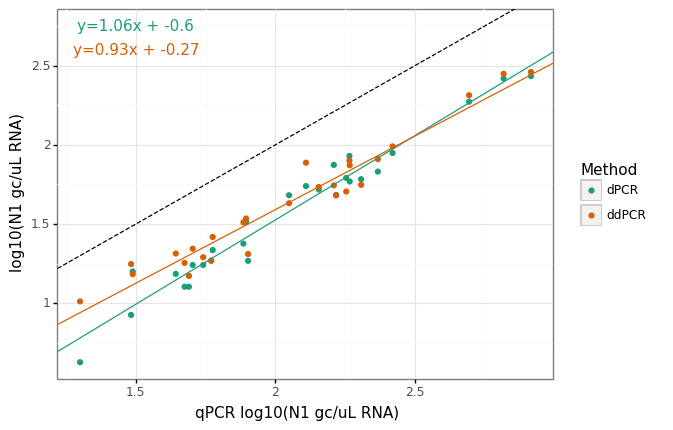

<ggplot: (377505503)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/FigS3.png


In [58]:
# Plot N1 linear regression of log10 scaled data
# x = qPCR
# y = dPCR and ddPCR

slope1 = corr_table.loc[(corr_table.Target == 'N1') & (corr_table.independent=='qPCR') & (corr_table.dependent=='dPCR'), 'slope'].values[0]
intercept1 = corr_table.loc[(corr_table.Target == 'N1') & (corr_table.independent=='qPCR') & (corr_table.dependent=='dPCR'), 'intercept'].values[0]

slope2 = corr_table.loc[(corr_table.Target == 'N1') & (corr_table.independent=='qPCR') & (corr_table.dependent=='ddPCR'), 'slope'].values[0]
intercept2 = corr_table.loc[(corr_table.Target == 'N1') & (corr_table.independent=='qPCR') & (corr_table.dependent=='ddPCR'), 'intercept'].values[0]

# melt so that both qPCR and ddPCR can be on y axis, with dPCR on x axis
# plot linear regression lines

colors=['#1b9e77', '#d95f02'] # dPCR, ddPCR
n1_corr_log10_melt = n1_corr_log10.melt(id_vars=['Sample','qPCR'], var_name='Method')
n1_corr_log10_melt.Method = pd.Categorical(n1_corr_log10_melt.Method, ordered=True, categories=['dPCR', 'ddPCR'])

plt = (ggplot(n1_corr_log10_melt, aes(x='qPCR', y='value', color='Method'))+
       geom_point()+
       geom_abline(intercept=0, slope=1, linetype='dashed')+
       xlab('qPCR log10(N1 gc/uL RNA)')+
       ylab('log10(N1 gc/uL RNA)')+
       scale_color_manual(values=colors)+
       #xlim(0.5,3)+
       #ylim(0.5,3)+
       geom_abline(slope=slope1, intercept=intercept1, color=colors[0]) +
       geom_abline(slope=slope2, intercept=intercept2, color=colors[1]) +
       theme_bw()+
       annotate('text', x= 1.5, y = 2.75, label = f'y={np.round(slope1, 2)}x + {np.round(intercept1, 2)}', color=colors[0])+
       annotate('text', x= 1.5, y = 2.6, label = f'y={np.round(slope2, 2)}x + {np.round(intercept2, 2)}', color=colors[1])
       )

display(plt)
ggsave(plt, '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/FigS3.png')

## Figure S4.

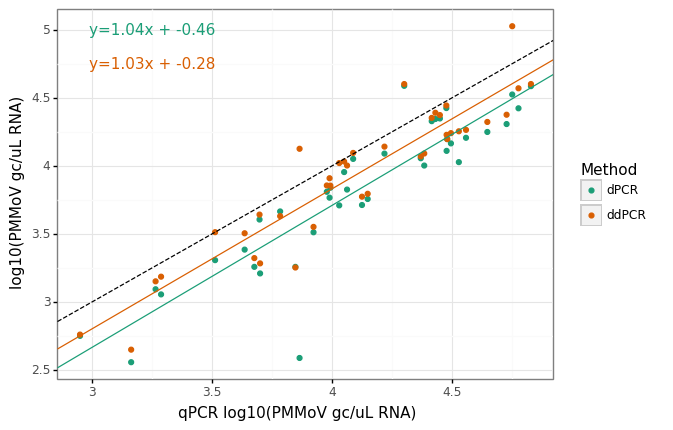

<ggplot: (378937597)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/FigS4.png


In [61]:
# Plot PMMoV linear regression of log10 scaled data
slope1 = corr_table.loc[(corr_table.Target == 'PMMoV') & (corr_table.independent=='qPCR') & (corr_table.dependent=='dPCR'), 'slope'].values[0]
intercept1 = corr_table.loc[(corr_table.Target == 'PMMoV') & (corr_table.independent=='qPCR') & (corr_table.dependent=='dPCR'), 'intercept'].values[0]

slope2 = corr_table.loc[(corr_table.Target == 'PMMoV') & (corr_table.independent=='qPCR') & (corr_table.dependent=='ddPCR'), 'slope'].values[0]
intercept2 = corr_table.loc[(corr_table.Target == 'PMMoV') & (corr_table.independent=='qPCR') & (corr_table.dependent=='ddPCR'), 'intercept'].values[0]


# melt so that both qPCR and ddPCR can be on y axis, with dPCR on x axis
# plot linear regression lines

colors=['#1b9e77', '#d95f02'] # dPCR, ddPCR
pmmov_corr_log10_melt = pmmov_corr_log10.melt(id_vars=['Sample','qPCR'], var_name='Method')
pmmov_corr_log10_melt.Method = pd.Categorical(pmmov_corr_log10_melt.Method, ordered=True, categories=['dPCR', 'ddPCR'])

plt = (ggplot(pmmov_corr_log10_melt, aes(x='qPCR', y='value', color='Method'))+
       geom_point()+
       geom_abline(intercept=0, slope=1, linetype='dashed')+
       xlab('qPCR log10(PMMoV gc/uL RNA)')+
       ylab('log10(PMMoV gc/uL RNA)')+
       scale_color_manual(values=colors)+
       #xlim(2.25,5)+
       #ylim(2.25,5)+
       geom_abline(slope=slope1, intercept=intercept1, color=colors[0]) +
       geom_abline(slope=slope2, intercept=intercept2, color=colors[1]) +
       theme_bw()+
       annotate('text', x= 3.25, y = 5, label = f'y={np.round(slope1, 2)}x + {np.round(intercept1, 2)}', color=colors[0])+
       annotate('text', x= 3.25, y = 4.75, label = f'y={np.round(slope2, 2)}x + {np.round(intercept2, 2)}', color=colors[1])

       )

display(plt)
ggsave(plt, '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/FigS4.png')

# Inhibition

In [45]:
inhibition_long = all_long[(all_long.Method != 'dPCR') &
                      (all_long.Dilution.isin([1,5])) &
                      (all_long.Target.isin(['N1', 'PMMoV']))]
# filter out negatives from ddPCR and qPCR
inhibition_long = inhibition_long[inhibition_long.Result != 'Negative']

inhibition_long = inhibition_long.drop(columns=['Result'])

# if saturated in ddPCR (for PMMoV), it will say 1000000 (*20/9) and we should drop it
inhibition_long = inhibition_long[inhibition_long.gc_per_uL_RNA != 2222222.22]
inhibition_long.head()

,Sample,Target,Dilution,gc_per_uL_RNA,Method
2,B_B_SQ_120620_1,N1,1.0,0.625940,qPCR
3,B_B_SQ_120620_1,N1,5.0,4.257019,qPCR
4,D_OSP_INF_120820_1,N1,1.0,30.366421,qPCR
5,D_OSP_INF_120820_1,N1,5.0,55.124975,qPCR
6,D_SEP_INF_120820_1,N1,1.0,29.749334,qPCR


In [46]:
inhibition = inhibition_long.pivot(index=['Sample', 'Method', 'Target'], columns='Dilution').reset_index()
inhibition
inhibition.columns = ['Sample', 'Method', 'Target', 'conc_undiluted', 'conc_5x']
inhibition['Inhibition_ratio'] = inhibition.conc_5x / inhibition.conc_undiluted
inhibition = inhibition.dropna()

# keep only samples that are matched within target (must have the same sample in both qPCR and ddPCR)
n1_ddpcr_samples = set(inhibition[(inhibition.Target=='N1') & (inhibition.Method == 'ddPCR')].Sample)
n1_qpcr_samples = set(inhibition[(inhibition.Target=='N1') & (inhibition.Method == 'qPCR')].Sample)
n1_samples = set.intersection(n1_ddpcr_samples, n1_qpcr_samples)

pmmov_ddpcr_samples = set(inhibition[(inhibition.Target=='PMMoV') & (inhibition.Method == 'ddPCR')].Sample)
pmmov_qpcr_samples = set(inhibition[(inhibition.Target=='PMMoV') & (inhibition.Method == 'qPCR')].Sample)
pmmov_samples = set.intersection(pmmov_ddpcr_samples, pmmov_qpcr_samples)

n1_drop = inhibition[(inhibition.Target=='N1') & (inhibition.Inhibition_ratio.isna())].Sample
pmmov_drop = inhibition[(inhibition.Target=='PMMoV') & (inhibition.Inhibition_ratio.isna())].Sample

inhibition = inhibition[((inhibition.Target=='N1') & ((inhibition.Sample.isin(n1_samples)))) | ((inhibition.Target=='PMMoV') & ((inhibition.Sample.isin(pmmov_samples))))]

## Figure 3

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff', '#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff', '#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/

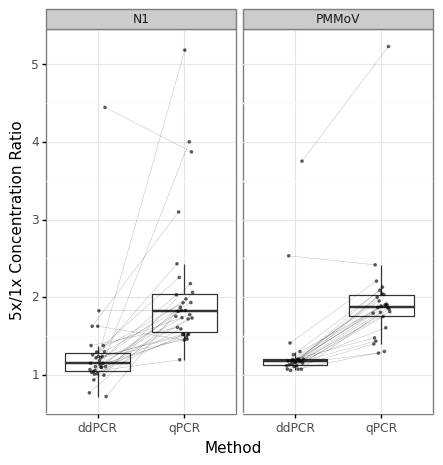

<ggplot: (345946435)>

In [47]:
plt = (ggplot(inhibition, aes(x='Method', y='Inhibition_ratio'))+
       geom_boxplot(outlier_shape='')+
       geom_line(aes(group='Sample'), size=0.1, alpha=0.5, position = position_dodge(0.2))+
       geom_point(aes(group='Sample'), alpha=0.5, size=0.5, position=position_dodge(0.2))+
       
       facet_wrap('~Target')+
       ylab('5x/1x Concentration Ratio')+
       xlab('Method')+
       theme_bw()+
       theme(figure_size=(5,5))
      )

display(plt)
# ggsave(plt, '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/Fig2.pdf')
# ggsave(plt, '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/Fig2.png')

## Compare 5:1 ratio for ddPCR and qPCR

Testing whether the difference between median inhibition ratios is significant.

First, are the inhibition ratios normally distributed? (No)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 16'. Pick better value with 'binwidth'.


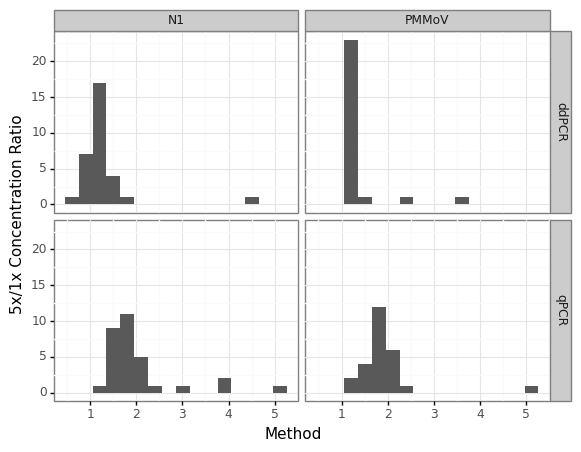

<ggplot: (346241753)>

In [48]:
plt = (ggplot(inhibition, aes(x='Inhibition_ratio'))+
       geom_histogram()+
       facet_grid('Method~Target')+
       ylab('5x/1x Concentration Ratio')+
       xlab('Method')+
       theme_bw()
      )

display(plt)

In [49]:
ir_n1_qpcr = inhibition[(inhibition.Method == 'qPCR') & (inhibition.Target == 'N1')].dropna().Inhibition_ratio
ir_pmmov_qpcr = inhibition[(inhibition.Method == 'qPCR') & (inhibition.Target == 'PMMoV')].dropna().Inhibition_ratio
display(stats.shapiro(ir_n1_qpcr))
display(stats.shapiro(ir_pmmov_qpcr))

ShapiroResult(statistic=0.6957374811172485, pvalue=1.0061204420708236e-06)

ShapiroResult(statistic=0.5547786951065063, pvalue=9.264763178862268e-08)

In [50]:
ir_n1_ddpcr = inhibition[(inhibition.Method == 'ddPCR') & (inhibition.Target == 'N1')].dropna().Inhibition_ratio
ir_pmmov_ddpcr = inhibition[(inhibition.Method == 'ddPCR') & (inhibition.Target == 'PMMoV')].dropna().Inhibition_ratio
display(stats.shapiro(ir_n1_ddpcr))
display(stats.shapiro(ir_pmmov_ddpcr))

ShapiroResult(statistic=0.4924715757369995, pvalue=3.0807820738942837e-09)

ShapiroResult(statistic=0.4144238829612732, pvalue=3.845941787261609e-09)

Failed Shapiro Wilkes test, so not normally distributed. Therefore use Mann Whitney U test instead of ANOVA.

In [51]:
# prepare data for Mann Whitney U test
inhibition_n1 = inhibition[(inhibition.Method != 'dPCR') & (inhibition.Target == 'N1')].dropna()
inhibition_n1 = inhibition_n1[['Sample', 'Method', 'Inhibition_ratio']].pivot(index='Sample', columns='Method').reset_index()
inhibition_n1.columns = ['Sample', 'ddPCR', 'qPCR']
inhibition_n1 = inhibition_n1.dropna()
display(len(inhibition_n1))

inhibition_pmmov = inhibition[(inhibition.Method != 'dPCR') & (inhibition.Target == 'PMMoV')].dropna()
inhibition_pmmov = inhibition_pmmov[['Sample', 'Method', 'Inhibition_ratio']].pivot(index='Sample', columns='Method').reset_index()
inhibition_pmmov.columns = ['Sample', 'ddPCR', 'qPCR']
inhibition_pmmov = inhibition_pmmov.dropna()
display(len(inhibition_pmmov))

31

26

In [52]:
inhibition_n1.head()

,Sample,ddPCR,qPCR
0,A_A_INF_120820_1,0.765799,1.753055
1,B_B_SD2_120920_1,1.066184,2.029903
2,C_C_N49_120920_1,1.147713,2.429640
3,C_C_S68_120920_1,1.375717,1.609642
4,D_OSP_INF_120820_1,1.029039,1.815327


In [53]:
# N1
display(inhibition_n1['ddPCR'].median().round(2))
display(inhibition_n1['qPCR'].median().round(2))
stats.mannwhitneyu(inhibition_n1['ddPCR'], inhibition_n1['qPCR'])

1.15

1.82

MannwhitneyuResult(statistic=75.0, pvalue=1.1853336573216924e-08)

In [54]:
# PMMoV
display(inhibition_pmmov['ddPCR'].median().round(2))
display(inhibition_pmmov['qPCR'].median().round(2))
stats.mannwhitneyu(inhibition_pmmov['ddPCR'], inhibition_pmmov['qPCR'])

1.17

1.88

MannwhitneyuResult(statistic=54.0, pvalue=2.1212285927195837e-07)

In [55]:
inhibition_pmmov.head()

,Sample,ddPCR,qPCR
0,A_A_INF_120820_1,1.115419,1.792519
1,B_B_SQ_120520_1,1.071859,1.396304
2,B_B_SQ_120620_1,1.177576,1.474357
3,D_SEP_Frank_121020_1,2.532807,2.416392
4,D_SEP_Friedman_120820_1,1.128135,1.432965


## Test whether there was significant inhibition by comparing median undiluted and 5x diluted

In [56]:
# compare results from 1x and 5x dilutions
inhibition_ddpcr_n1 = inhibition[(inhibition.Method == 'ddPCR') &
           (inhibition.Target == 'N1')][['conc_undiluted', 'conc_5x']].dropna()

stats.mannwhitneyu(inhibition_ddpcr_n1['conc_undiluted'], inhibition_ddpcr_n1['conc_5x'])

MannwhitneyuResult(statistic=436.0, pvalue=0.5356151849321827)

In [57]:
stats.wilcoxon(inhibition_ddpcr_n1['conc_undiluted'], inhibition_ddpcr_n1['conc_5x'])

WilcoxonResult(statistic=33.0, pvalue=2.5171416880511184e-05)

In [58]:
# compare results from 1x and 5x dilutions
inhibition_ddpcr_pmmov = inhibition[(inhibition.Method == 'ddPCR') &
           (inhibition.Target == 'PMMoV')][['conc_undiluted', 'conc_5x']].dropna()

stats.mannwhitneyu(inhibition_ddpcr_pmmov['conc_undiluted'], inhibition_ddpcr_pmmov['conc_5x'])

MannwhitneyuResult(statistic=285.0, pvalue=0.3366464533272586)

In [59]:
stats.wilcoxon(inhibition_ddpcr_pmmov['conc_undiluted'], inhibition_ddpcr_pmmov['conc_5x'])

WilcoxonResult(statistic=0.0, pvalue=8.29809930635731e-06)

In [60]:
# compare results from 1x and 5x dilutions
inhibition_qpcr_n1 = inhibition[(inhibition.Method == 'qPCR') &
           (inhibition.Target == 'N1')][['conc_undiluted', 'conc_5x']].dropna()

stats.mannwhitneyu(inhibition_qpcr_n1['conc_undiluted'], inhibition_qpcr_n1['conc_5x'])

MannwhitneyuResult(statistic=322.0, pvalue=0.02612056090330662)

In [61]:
stats.wilcoxon(inhibition_qpcr_n1['conc_undiluted'], inhibition_qpcr_n1['conc_5x'])

WilcoxonResult(statistic=0.0, pvalue=1.1741945398998534e-06)

In [62]:
# compare results from 1x and 5x dilutions
inhibition_qpcr_pmmov = inhibition[(inhibition.Method == 'qPCR') &
           (inhibition.Target == 'PMMoV')][['conc_undiluted', 'conc_5x']].dropna()

stats.mannwhitneyu(inhibition_qpcr_pmmov['conc_undiluted'], inhibition_qpcr_pmmov['conc_5x'])

MannwhitneyuResult(statistic=227.0, pvalue=0.043147274227167166)

In [63]:
stats.wilcoxon(inhibition_qpcr_pmmov['conc_undiluted'], inhibition_qpcr_pmmov['conc_5x'])

WilcoxonResult(statistic=0.0, pvalue=8.29809930635731e-06)

In [64]:
inhibition_long.Dilution = inhibition_long.Dilution.astype('category')
inhibition_long.head()

,Sample,Target,Dilution,gc_per_uL_RNA,Method
2,B_B_SQ_120620_1,N1,1.0,0.625940,qPCR
3,B_B_SQ_120620_1,N1,5.0,4.257019,qPCR
4,D_OSP_INF_120820_1,N1,1.0,30.366421,qPCR
5,D_OSP_INF_120820_1,N1,5.0,55.124975,qPCR
6,D_SEP_INF_120820_1,N1,1.0,29.749334,qPCR


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/homebrew/Caskroom/miniforge/base/lib/py

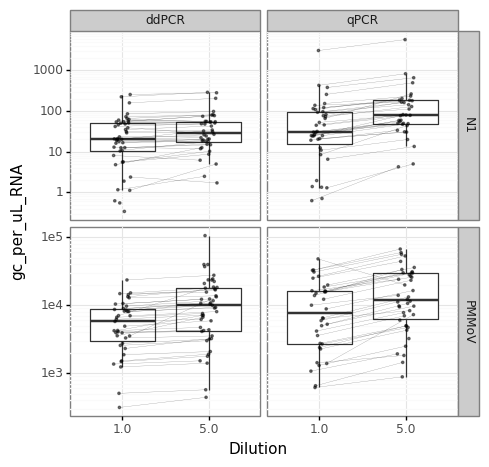

<ggplot: (345632088)>

In [65]:
plt = (ggplot(inhibition_long, aes(x='Dilution', y='gc_per_uL_RNA'))+
       geom_boxplot(outlier_shape='')+
       geom_line(aes(group='Sample'), size=0.1, alpha=0.5, position = position_dodge(0.2))+
       geom_point(aes(group='Sample'), alpha=0.5, size=0.5, position=position_dodge(0.2))+
       facet_grid('Target~Method', scales='free_y')+
       scale_y_log10()+
       ylab('gc_per_uL_RNA')+
       xlab('Dilution')+
       theme_bw()+
       theme(figure_size=(5,5))
      )

display(plt)
# ggsave(plt, '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/Fig2.pdf')
# ggsave(plt, '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/pcr_paper/figures/Fig2.png')

# Positivity agreement (N1)

In [66]:
N1_positivity = all[(all.Target == 'N1') & (all.Dilution == 1)].dropna()

display(len(N1_positivity))

display(len(N1_positivity[N1_positivity.Result_qPCR == 'Negative']))
display(len(N1_positivity[N1_positivity.Result_dPCR == 'Negative']))
display(len(N1_positivity[N1_positivity.Result_ddPCR == 'Negative']))

# of 40 samples qPCR reported 3 negatives, dPCR reported 10, and ddPCR reported 3.  All but one of these were in residential sewersheds (buildings or campuses).

40

3

10

3

Of 40 samples qPCR reported 3 negatives, dPCR reported 10, and ddPCR reported 3.  All but one of these were in residential sewersheds (buildings or campuses).

In [67]:
all_positive = N1_positivity[((N1_positivity.Result_ddPCR == 'Positive') &
               (N1_positivity.Result_dPCR == 'Positive') &
               (N1_positivity.Result_qPCR == 'Positive'))]

len(all_positive)

29

In [68]:
# inspect samples with at least one negative
N1_positivity[((N1_positivity.Result_ddPCR == 'Negative') |
               (N1_positivity.Result_dPCR == 'Negative') |
               (N1_positivity.Result_qPCR == 'Negative'))].sort_values(['Result_qPCR', 'Result_dPCR', 'Result_ddPCR'])

,Sample,Dilution,Target,gc_per_uL_RNA_qPCR,gc_per_uL_RNA_dPCR,gc_per_uL_RNA_ddPCR,Result_qPCR,Result_dPCR,Result_ddPCR
0,B_B_SQ_120520_1,1.0,N1,0.000000,0.00,0.00,Negative,Negative,Negative
104,D_SEP_Frank_121020_1,1.0,N1,0.000000,0.00,0.00,Negative,Negative,Negative
44,D_SEP_Frank_120820_1,1.0,N1,0.000000,5.31,1.16,Negative,Positive,Positive
2,B_B_SQ_120620_1,1.0,N1,0.625940,0.00,0.00,Positive,Negative,Negative
64,A_A_INF_120820_1,1.0,N1,19.175900,1.08,8.07,Positive,Negative,Positive
138,B_B_SQ_120820_1,1.0,N1,1.390000,0.00,0.62,Positive,Negative,Positive
48,D_SEP_Koret_120820_1,1.0,N1,1.951214,0.00,0.55,Positive,Negative,Positive
10,J_J_Kerr_120820_1,1.0,N1,1.338514,0.00,1.89,Positive,Negative,Positive
144,J_J_Kerr_121020_1,1.0,N1,0.707228,0.54,0.34,Positive,Negative,Positive
78,N_N_Veteran_120820_1,1.0,N1,1.293092,0.54,1.12,Positive,Negative,Positive



## Add MHV recovery

In [69]:
mhv_df.head()

,Target,Sample,Dilution,gc_per_uL_RNA,Result,spike_MHV_gc,Method,recovered_mhv_gc,recovery_perc
215,MHV,Q_Q_CMF_120720_1,10.0,5331.56,Positive,708000.0,ddPCR,1066312.0,150.609040
217,MHV,B_B_SQ_120520_1,10.0,2001.78,Positive,708000.0,ddPCR,400356.0,56.547458
219,MHV,B_B_SQ_120620_1,10.0,3180.67,Positive,708000.0,ddPCR,636134.0,89.849435
221,MHV,H_H_INF_120320_1,10.0,1914.22,Positive,708000.0,ddPCR,382844.0,54.074011
223,MHV,J_J_UCV_120820_1,10.0,4430.00,Positive,708000.0,ddPCR,886000.0,125.141243


In [70]:
N1_positivity = N1_positivity.merge(mhv_df[['Sample', 'recovery_perc']])

# inspect samples with at least one negative
N1_positivity[((N1_positivity.Result_ddPCR == 'Negative') |
               (N1_positivity.Result_dPCR == 'Negative') |
               (N1_positivity.Result_qPCR == 'Negative'))].sort_values(['Result_qPCR', 'Result_dPCR', 'Result_ddPCR'])

,Sample,Dilution,Target,gc_per_uL_RNA_qPCR,gc_per_uL_RNA_dPCR,gc_per_uL_RNA_ddPCR,Result_qPCR,Result_dPCR,Result_ddPCR,recovery_perc
2,B_B_SQ_120520_1,1.0,N1,0.000000,0.00,0.00,Negative,Negative,Negative,56.547458
11,D_SEP_Frank_121020_1,1.0,N1,0.000000,0.00,0.00,Negative,Negative,Negative,117.793475
10,D_SEP_Frank_120820_1,1.0,N1,0.000000,5.31,1.16,Negative,Positive,Positive,57.533051
3,B_B_SQ_120620_1,1.0,N1,0.625940,0.00,0.00,Positive,Negative,Negative,89.849435
0,A_A_INF_120820_1,1.0,N1,19.175900,1.08,8.07,Positive,Negative,Positive,53.038418
4,B_B_SQ_120820_1,1.0,N1,1.390000,0.00,0.62,Positive,Negative,Positive,141.880734
15,D_SEP_Koret_120820_1,1.0,N1,1.951214,0.00,0.55,Positive,Negative,Positive,42.084181
25,J_J_Kerr_120820_1,1.0,N1,1.338514,0.00,1.89,Positive,Negative,Positive,73.521751
26,J_J_Kerr_121020_1,1.0,N1,0.707228,0.54,0.34,Positive,Negative,Positive,0.004407
37,N_N_Veteran_120820_1,1.0,N1,1.293092,0.54,1.12,Positive,Negative,Positive,56.767232


## Compare N1 and N2 positivity

N1 and the N2 from the triplex assay appear to have similar sensitivity

### ddPCR

In [71]:
all.head()

,Sample,Dilution,Target,gc_per_uL_RNA_qPCR,gc_per_uL_RNA_dPCR,gc_per_uL_RNA_ddPCR,Result_qPCR,Result_dPCR,Result_ddPCR
64,A_A_INF_120820_1,1.0,N1,19.175900,1.080,8.07,Positive,Negative,Positive
65,A_A_INF_120820_1,5.0,N1,33.616407,NaN,6.18,Positive,NaN,Positive
464,B_B_RV_120820_1,1.0,N1,NaN,6.885,12.95,NaN,Positive,Positive
465,B_B_RV_120820_1,5.0,N1,NaN,NaN,11.86,NaN,NaN,Positive
136,B_B_SD2_120920_1,1.0,N1,24.907725,17.415,20.70,Positive,Positive,Positive


In [72]:
# make table of ddPCR results with N1 and N2 positives as columns
ddpcr_n1n2 = all[(all.Target.isin(['N1', 'N2', 'E'])) & (all.Dilution == 1)][['Sample', 'Target', 'Result_ddPCR']].copy()
ddpcr_n1n2 = ddpcr_n1n2.pivot(index='Sample', columns='Target').reset_index()
ddpcr_n1n2.columns = ['Sample', 'N1', 'N2', 'E']
ddpcr_n1n2 = ddpcr_n1n2.sort_values(['N1', 'N2', 'E'])

In [73]:
ddpcr_sensitivity = ddpcr_raw[(ddpcr_raw.Dilution == 1) &
                              (ddpcr_raw.Target.isin(['N1', 'N2', 'E'])) & 
                              (~ddpcr_raw.Sample.isin(['NTC', 'PC', 'PC+MHV']))][['Target', 'Sample', 'Positives']].copy()
ddpcr_sensitivity = ddpcr_sensitivity.pivot(index='Sample', columns='Target').reset_index()
ddpcr_sensitivity.columns = ['Sample', 'E', 'N1', 'N2']
ddpcr_sensitivity = ddpcr_sensitivity[['Sample', 'N1', 'N2', 'E']]
ddpcr_sensitivity = ddpcr_sensitivity.merge(ddpcr_n1n2, on='Sample', suffixes=('_positives', '_result')).sort_values(['N1_result', 
                                                                                                  'N2_result',
                                                                                                  'E_result'])
ddpcr_sensitivity

,Sample,N1_positives,N2_positives,E_positives,N1_result,N2_result,E_result
3,B_B_SQ_120520_1,0,1,0,Negative,Negative,Negative
4,B_B_SQ_120620_1,0,1,1,Negative,Negative,Negative
5,B_B_SQ_120720_1,0,0,0,Negative,Negative,Negative
15,D_SEP_Frank_121020_1,0,0,0,Negative,Negative,Negative
20,D_SEP_Koret_120820_1,2,2,0,Positive,Negative,Negative
46,N_N_Veteran_120820_1,6,1,2,Positive,Negative,Negative
14,D_SEP_Frank_120820_1,7,0,49,Positive,Negative,Positive
6,B_B_SQ_120820_1,4,6,0,Positive,Positive,Negative
32,J_J_Kerr_121020_1,2,3,1,Positive,Positive,Negative
0,A_A_INF_120820_1,43,38,32,Positive,Positive,Positive


### dPCR

Using 3 positives across 2 wells, N2 called 3 more positive samples than N1

In [74]:
# set up positives to get the result column
dpcr_raw.Positives = pd.to_numeric(dpcr_raw.Positives)
dpcr_sensitivity = dpcr_raw[['Sample', 'Target', 'Positives']].groupby(['Sample', 'Target']).agg(                                                    
                                                    positives_sum=('Positives','sum')).reset_index() # two reps were run, avg gc and sum positives

dpcr_sensitivity = dpcr_sensitivity[dpcr_sensitivity.Target.isin(['N1', 'N2'])][['Sample', 'Target', 'positives_sum']]
dpcr_sensitivity = dpcr_sensitivity.pivot(index='Sample', columns='Target').reset_index()
dpcr_sensitivity.columns = ['Sample', 'N1', 'N2']
dpcr_sensitivity.sort_values(['N1', 'N2'])

,Sample,N1,N2
3,B_B_SQ_120520_1,0,0
4,B_B_SQ_120620_1,0,0
6,B_B_SQ_120820_1,0,0
15,D_SEP_Frank_121020_1,0,0
19,D_SEP_Koret_120820_1,0,0
31,J_J_Kerr_120820_1,0,0
5,B_B_SQ_120720_1,0,1
48,Q_Q_CMF_120720_1,0,1
46,N_N_Veteran_120820_1,1,6
32,J_J_Kerr_121020_1,1,8
